In [42]:
!apt-get install -y graphviz libgraphviz-dev pkg-config
!pip install pygraphviz --no-binary :all:

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 35 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,671 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config a

In [1]:
import heapq
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque

In [2]:
def heuristic(a, b):
  """Manhattan distance"""
  return abs(a[0] - b[0]) + abs(a[1] - b[1])

In [3]:
def neighbors(node, n, m, obstacles):
  """Generate valid neighbors"""
  moves = [(0,1),(1,0),(0,-1),(-1,0)]
  out = []
  for dx, dy in moves:
    x, y = node[0] + dx, node[1] + dy
    if 0 <= x < n and 0 <= y <= m and (x, y) not in obstacles:
      out.append((x,y))
  return out

In [14]:
def search(method, start, goal, n, m, obstacles):
  parents = {start: None}
  visited = set()
  queue = []
  tree = []
  queue_history = []

  if method == "bfs":
    queue = deque([start])
  elif method == "dfs":
    queue = [start]
  elif method in ["a*", "greedy"]:
    queue = []
    h = heuristic(start, goal)
    heapq.heappush(queue, (h, 0, start))

  while queue:
    if method in ["a*", "greedy"]:
      queue_history.append(list(queue))
    else:
      queue_history.append(list(queue))

    if method == "bfs":
      current = queue.popleft()
      g = 0
    elif method == "dfs":
      current = queue.pop()
      g = 0
    elif method in ["a*", "greedy"]:
      f, g, current = heapq.heappop(queue)

    visited.add(current)

    if current == goal:
      break

    for ne in neighbors(current, n, m, obstacles):
      if ne not in visited and ne not in parents:
        parents[ne] = current
        tree.append((current, ne))

        if method == "bfs":
          queue.append(ne)
        elif method == "dfs":
          queue.append(ne)
        elif method == "greedy":
          h = heuristic(ne, goal)
          heapq.heappush(queue, (h, 0, ne))
        elif method == "a*":
          h = heuristic(ne, goal)
          heapq.heappush(queue, (g+1+h, g+1, ne))

  path = []
  node = goal
  while node:
    path.append(node)
    node = parents.get(node)
  path.reverse()

  return path, tree, parents, queue_history

In [36]:
def draw_grid(n, m, start, goal, obstacles, path):
  grid = [[" "]*m for _ in range(n)]
  for ox, oy in obstacles:
    grid[ox][oy] = "x"
  for cx, cy in path:
    grid[cx][cy] = "."
  sx, sy = start
  gx, gy = goal
  grid[sx][sy] = "s"
  grid[gx][gy] = "g"

  fig, ax = plt.subplots()
  ax.imshow([[1 if grid[i][j]=="x" else 0 for j in range(m)] for i in range(n)], cmap="gray_r")

  for i in range(n):
    for j in range(m):
      ax.text(j, i, grid[i][j], ha="center", va="center", color="black", fontsize=30, fontweight="bold" if grid[i][j]!=" " else "black")

  ax.set_xticks([x-0.5 for x in range(1,m)], minor=True)
  ax.set_yticks([y-0.5 for y in range(1,n)], minor=True)
  ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
  ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

  plt.title("Path")
  plt.show()

In [56]:
def draw_tree(tree, goal):
    G = nx.DiGraph()
    G.add_edges_from(tree)

    labels = {}
    for node in G.nodes():
        h = heuristic(node, goal)
        labels[node] = f"{node}\nh={h}"

    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    except:
        pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(10, 8))
    nx.draw(
        G, pos,
        with_labels=False,
        node_color="lightblue",
        node_size=1200,
        font_size=8,
        arrows=True
    )
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    plt.title("Search Tree")
    plt.show()

In [57]:
def draw_queue_states(queue_history):
    for step, queue in enumerate(queue_history):
        fig, ax = plt.subplots(figsize=(len(queue), 2))

        for i, elem in enumerate(queue):
            if isinstance(elem, tuple) and len(elem) == 2:
                x, y = elem
            elif isinstance(elem, tuple) and isinstance(elem[-1], tuple):
                x, y = elem[-1]
            else:
                continue

            rect = plt.Rectangle((i, 0), 1, 1, edgecolor="black", facecolor="lightblue")
            ax.add_patch(rect)
            ax.text(i + 0.5, 0.5, f"({x},{y})", ha="center", va="center", fontsize=10)

        ax.set_xlim(0, len(queue))
        ax.set_ylim(0, 1)
        ax.set_aspect("equal")
        ax.axis("off")

        plt.title(f"Queue at step {step}")
        plt.show()

Path found [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (5, 2), (5, 3), (5, 4), (5, 5)]


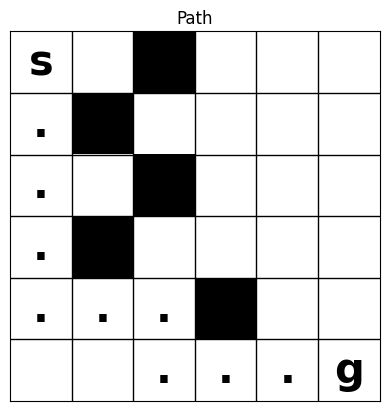

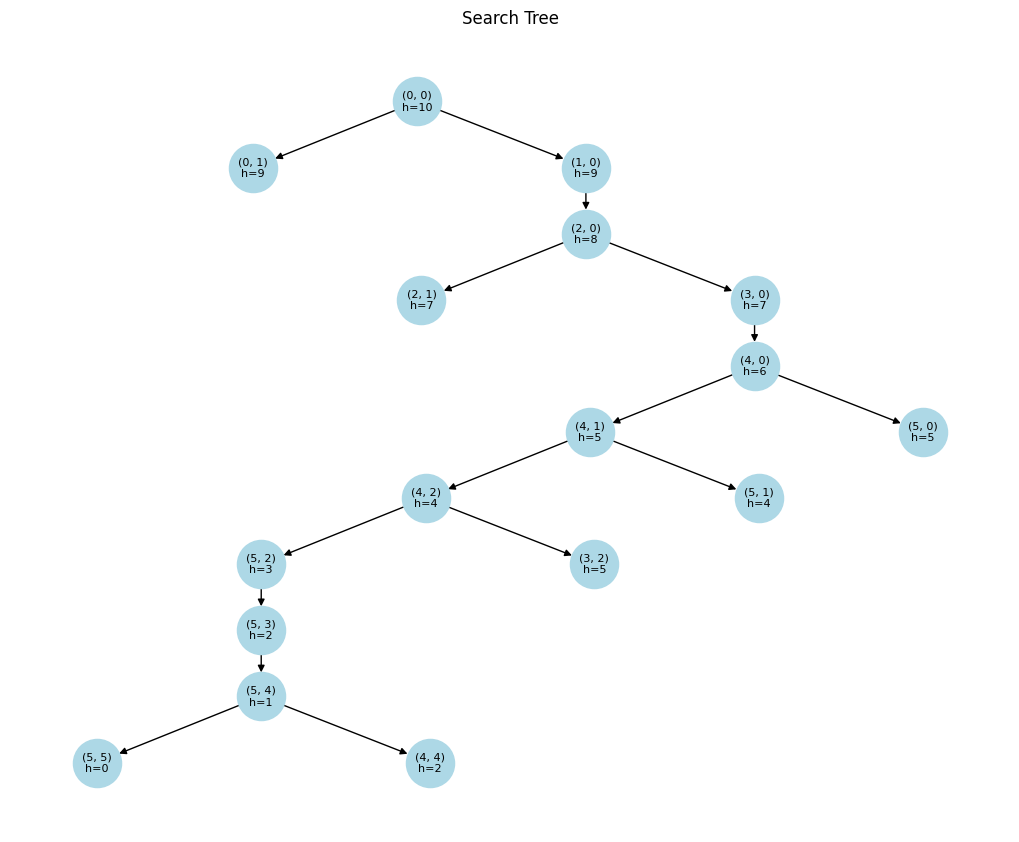

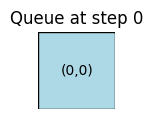

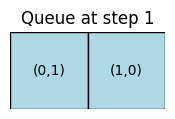

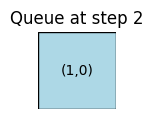

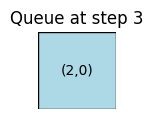

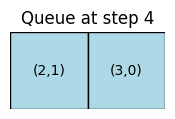

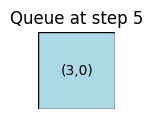

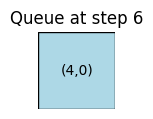

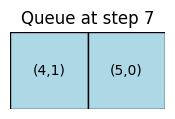

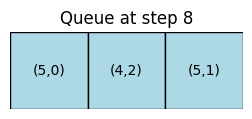

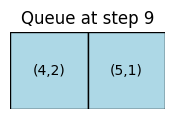

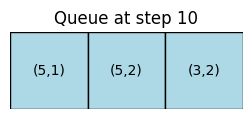

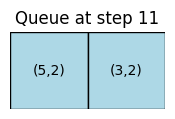

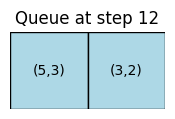

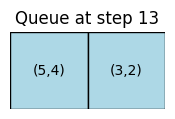

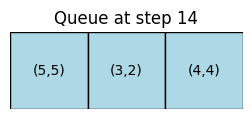

In [59]:
n, m = 6, 6
start = (0,0)
goal = (5,5)
obstacles = [(0,2),(1,1),(2,2),(3,1),(4,3)]
method = "a*"

path, tree, parents, queue_history = search(method, start, goal, n, m, obstacles)

print("Path found", path)

draw_grid(n, m, start, goal, obstacles, path)
draw_tree(tree, goal)
draw_queue_states(queue_history)